### 1. Importações e Carregamento de Dados

In [34]:
import pandas as pd
import numpy as np
import os
import heapq
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Adicionado para evitar memory leak do KMeans no Windows com MKL
os.environ['OMP_NUM_THREADS'] = '2'

# --- Caminhos para os arquivos ---
BASE_PATH = '../data/94x94_408v/'
RESULTS_PATH = '../results/'
CLUSTERING_PATH = os.path.join(RESULTS_PATH, 'clustering')
UNIFICATION_PATH = os.path.join(RESULTS_PATH, 'unification') # Mantido para o known_map

# --- Carregar Vítimas Clusterizadas ---
# Carrega as vítimas dos arquivos de cluster pré-definidos.
# O número do arquivo (1-4) define a prioridade.
clusters = []
try:
    for i in range(1, 5): # Itera de 1 a 4 para os clusters de prioridade
        cluster_filepath = os.path.join(CLUSTERING_PATH, f'tlim8000_cluster{i}.csv')
        df = pd.read_csv(cluster_filepath)
        df['priority'] = i # Prioridade é definida pelo número do arquivo
        clusters.append(df)
    
    victims = pd.concat(clusters, ignore_index=True)
    
    # Renomear colunas para o padrão ('linha', 'coluna') se necessário
    if 'x' in victims.columns and 'y' in victims.columns:
        victims.rename(columns={'x': 'coluna', 'y': 'linha'}, inplace=True)
        
    print(f"Carregadas {len(victims)} vítimas de {len(clusters)} arquivos de cluster.")
    print("Contagem de vítimas por prioridade:")
    print(victims['priority'].value_counts().sort_index())

except FileNotFoundError as e:
    print(f"Arquivos de cluster não encontrados: {e}. Certifique-se de que os arquivos tlim8000_cluster{{i}}.csv existem.")
    victims = pd.DataFrame() # Dataframe vazio para não quebrar o resto

# --- Carregar Configurações do Ambiente ---
with open(os.path.join(BASE_PATH, 'env_config.txt')) as f:
    env_config = f.readlines()

conf = {}
for line in env_config:
    key, value = line.strip().split()
    conf[key] = value

coords = conf['BASE'].split(',')
BASE = (int(coords[0]), int(coords[1]))
grid_w, grid_h = int(conf["GRID_WIDTH"]), int(conf["GRID_HEIGHT"])

# --- Carregar Obstáculos (Apenas para consulta de custo) ---
def read_env_obstacles(path, grid_size):
    grid = np.ones(grid_size) # Inicia com custo 1
    with open(path) as f:
        for line in f:
            r, c, v = line.strip().split(',')
            grid[int(r), int(c)] = float(v)
    return grid

env_obst_path = os.path.join(BASE_PATH, 'env_obst.txt')
env_obst = read_env_obstacles(env_obst_path, (grid_h, grid_w))

# --- Carregar Mapa Unificado e Construir Grade de Custos Conhecida ---
# A grade de custos (known_grid) será usada pelo A*. Células não presentes no
# knownmap terão custo infinito, tornando-as intransponíveis.
try:
    known_map_path = os.path.join(UNIFICATION_PATH, 'tlim8000_knownmap_all.csv')
    knownmap_df = pd.read_csv(known_map_path)
    
    # 1. Iniciar a grade com custo infinito para todas as células.
    known_grid = np.full(env_obst.shape, np.inf)
    
    # 2. Para cada célula no mapa conhecido, atribuir o custo do 'env_obst'.
    rows = knownmap_df['linha'].values
    cols = knownmap_df['coluna'].values
    known_grid[rows, cols] = env_obst[rows, cols]
    
    print(f"Mapa de custos construído com {len(knownmap_df)} células conhecidas.")
    
except FileNotFoundError:
    print("Mapa unificado não encontrado! O planejamento de rota não será possível.")
    # Cria uma grade vazia/infinita se o mapa não for encontrado
    known_grid = np.full(env_obst.shape, np.inf)

# Cache para armazenar custos de rotas já calculadas
cost_cache = {}

Carregadas 286 vítimas de 4 arquivos de cluster.
Contagem de vítimas por prioridade:
priority
1    67
2    69
3    85
4    65
Name: count, dtype: int64
Mapa de custos construído com 6158 células conhecidas.


### 2. Algoritmo A* e Funções de Custo

As funções abaixo são usadas para calcular o custo de deslocamento entre dois pontos no mapa conhecido. O A* encontra o caminho mais curto, e usamos um cache para evitar recalcular rotas repetidamente.

In [35]:
def heuristic(a, b):
    """Heurística de distância diagonal para o A*."""
    dx, dy = abs(a[0] - b[0]), abs(a[1] - b[1])
    return 1.0 * (dx + dy) + (1.5 - 2 * 1.0) * min(dx, dy)

def astar_cost(grid, start, goal):
    """Executa o A* e retorna apenas o custo do caminho."""
    if start == goal:
        return 0
    
    rows, cols = grid.shape
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    open_set = [(0, start)]
    g_score = {start: 0}
    
    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            return g_score[current]

        x, y = current
        for dx, dy in moves:
            nx, ny = x + dx, y + dy

            if not (0 <= nx < rows and 0 <= ny < cols) or grid[nx, ny] == np.inf:
                continue

            move_cost = grid[nx, ny] * (1.5 if abs(dx) + abs(dy) == 2 else 1.0)
            new_g = g_score[current] + move_cost

            if (nx, ny) not in g_score or new_g < g_score[(nx, ny)]:
                g_score[(nx, ny)] = new_g
                f_score = new_g + heuristic((nx, ny), goal)
                heapq.heappush(open_set, (f_score, (nx, ny)))
                
    return np.inf # Retorna infinito se não houver caminho

def get_astar_cost(grid, a, b):
    """Wrapper para o A* que utiliza um cache de custos."""
    # Garante que a chave do cache seja sempre a mesma, independente da ordem
    key = tuple(sorted((a, b)))
    if key in cost_cache:
        return cost_cache[key]
    
    cost = astar_cost(grid, a, b)
    cost_cache[key] = cost
    return cost

### 5. Planejamento com Limite de Custo e Execução

Para atender ao requisito de que os agentes devem operar com um limite de bateria (custo), modificamos a lógica de planejamento. A função `plan_individual_route_with_limit` constrói a rota de forma incremental, adicionando a próxima vítima mais vantajosa (considerando prioridade e custo) apenas se a viagem não exceder o `max_cost`.

As vítimas que não podem ser resgatadas dentro do limite de custo de um agente são retornadas como "órfãs" e podem ser realocadas ou deixadas para uma próxima fase.

In [36]:
# --- Parâmetros ---
N_AGENTS = 3
MAX_COST_PER_AGENT = 800 # Limite de custo por agente

# --- Execução do Planejamento com Setorização e Limite de Custo ---
agent_routes_limited = []
all_rescued_victims_list = []
all_orphan_victims_list = []

# 1. Setorizar todas as vítimas primeiro
print(f"Setorizando vítimas para {N_AGENTS} socorristas...")
if not victims.empty:
    agent_victim_groups = assign_victims_to_agents(victims, N_AGENTS)
else:
    agent_victim_groups = []
    print("Nenhuma vítima para atribuir.")

print(f"\nIniciando planejamento com limite de custo de {MAX_COST_PER_AGENT} por agente.")

# 2. Planejar para cada agente dentro do seu setor
if agent_victim_groups:
    for i, agent_victims in enumerate(agent_victim_groups):
        print(f"\n--- Planejando para Socorrista {i+1} (Setor com {len(agent_victims)} vítimas) ---")
        
        if agent_victims.empty:
            print("--> Nenhuma vítima neste setor.")
            agent_routes_limited.append([])
            continue

        # Planeja a rota para o agente APENAS com as vítimas do seu setor
        route, orphans_in_sector = plan_route_with_limit(agent_victims, known_grid, BASE, MAX_COST_PER_AGENT)
        
        # Calcula o custo real da rota planejada
        cost = calculate_total_cost(route, known_grid)
        
        # Identifica as vítimas que foram resgatadas nesta rota
        rescued_coords = set(route) - {BASE}
        rescued_mask = agent_victims.apply(lambda row: (row['linha'], row['coluna']) in rescued_coords, axis=1)
        rescued_in_this_run = agent_victims[rescued_mask]
        
        # Adiciona os resultados às listas
        agent_routes_limited.append(route)
        if not rescued_in_this_run.empty:
            all_rescued_victims_list.append(rescued_in_this_run)
        if not orphans_in_sector.empty:
            all_orphan_victims_list.append(orphans_in_sector)

        print(f"--> Rota planejada com {len(rescued_in_this_run)} vítimas resgatadas.")
        print(f"--> Custo total da rota: {cost:.2f} / {MAX_COST_PER_AGENT}")
        if not orphans_in_sector.empty:
            print(f"--> Vítimas não resgatadas no setor (sem orçamento): {len(orphans_in_sector)}")

# --- Resultados Finais ---
print("\n--- Resumo Geral do Planejamento ---")

# Concatena todos os dataframes de vítimas resgatadas e órfãs
rescued_victims_df = pd.DataFrame()
if all_rescued_victims_list:
    rescued_victims_df = pd.concat(all_rescued_victims_list, ignore_index=True)

unassigned_victims = pd.DataFrame()
if all_orphan_victims_list:
    unassigned_victims = pd.concat(all_orphan_victims_list, ignore_index=True)

print(f"Total de vítimas resgatadas: {len(rescued_victims_df)}")
print(f"Total de vítimas não resgatadas (órfãs): {len(unassigned_victims)}")

# Detalhar vítimas resgatadas por prioridade
if not rescued_victims_df.empty:
    print("\nContagem de resgatados por prioridade:")
    print(rescued_victims_df['priority'].value_counts().sort_index().to_string())

# Detalhar vítimas não resgatadas
if not unassigned_victims.empty:
    print("\nDetalhes das vítimas não resgatadas:")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(unassigned_victims)
else:
    print("\nTodas as vítimas foram resgatadas!")

Setorizando vítimas para 3 socorristas...

Iniciando planejamento com limite de custo de 800 por agente.

--- Planejando para Socorrista 1 (Setor com 106 vítimas) ---


c:\Users\Pieri\anaconda3\envs\datascience\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--> Rota planejada com 91 vítimas resgatadas.
--> Custo total da rota: 795.50 / 800
--> Vítimas não resgatadas no setor (sem orçamento): 15

--- Planejando para Socorrista 2 (Setor com 102 vítimas) ---
--> Rota planejada com 89 vítimas resgatadas.
--> Custo total da rota: 511.00 / 800
--> Vítimas não resgatadas no setor (sem orçamento): 13

--- Planejando para Socorrista 3 (Setor com 78 vítimas) ---
--> Rota planejada com 74 vítimas resgatadas.
--> Custo total da rota: 613.50 / 800
--> Vítimas não resgatadas no setor (sem orçamento): 4

--- Resumo Geral do Planejamento ---
Total de vítimas resgatadas: 254
Total de vítimas não resgatadas (órfãs): 32

Contagem de resgatados por prioridade:
priority
1    61
2    61
3    77
4    55

Detalhes das vítimas não resgatadas:
     id  coluna  linha      sobr  tri  priority  agent_assignment
0     7      39     84  0.122102    3         1                 0
1   104       6     28  0.122102    3         1                 0
2   107       2     28  0.

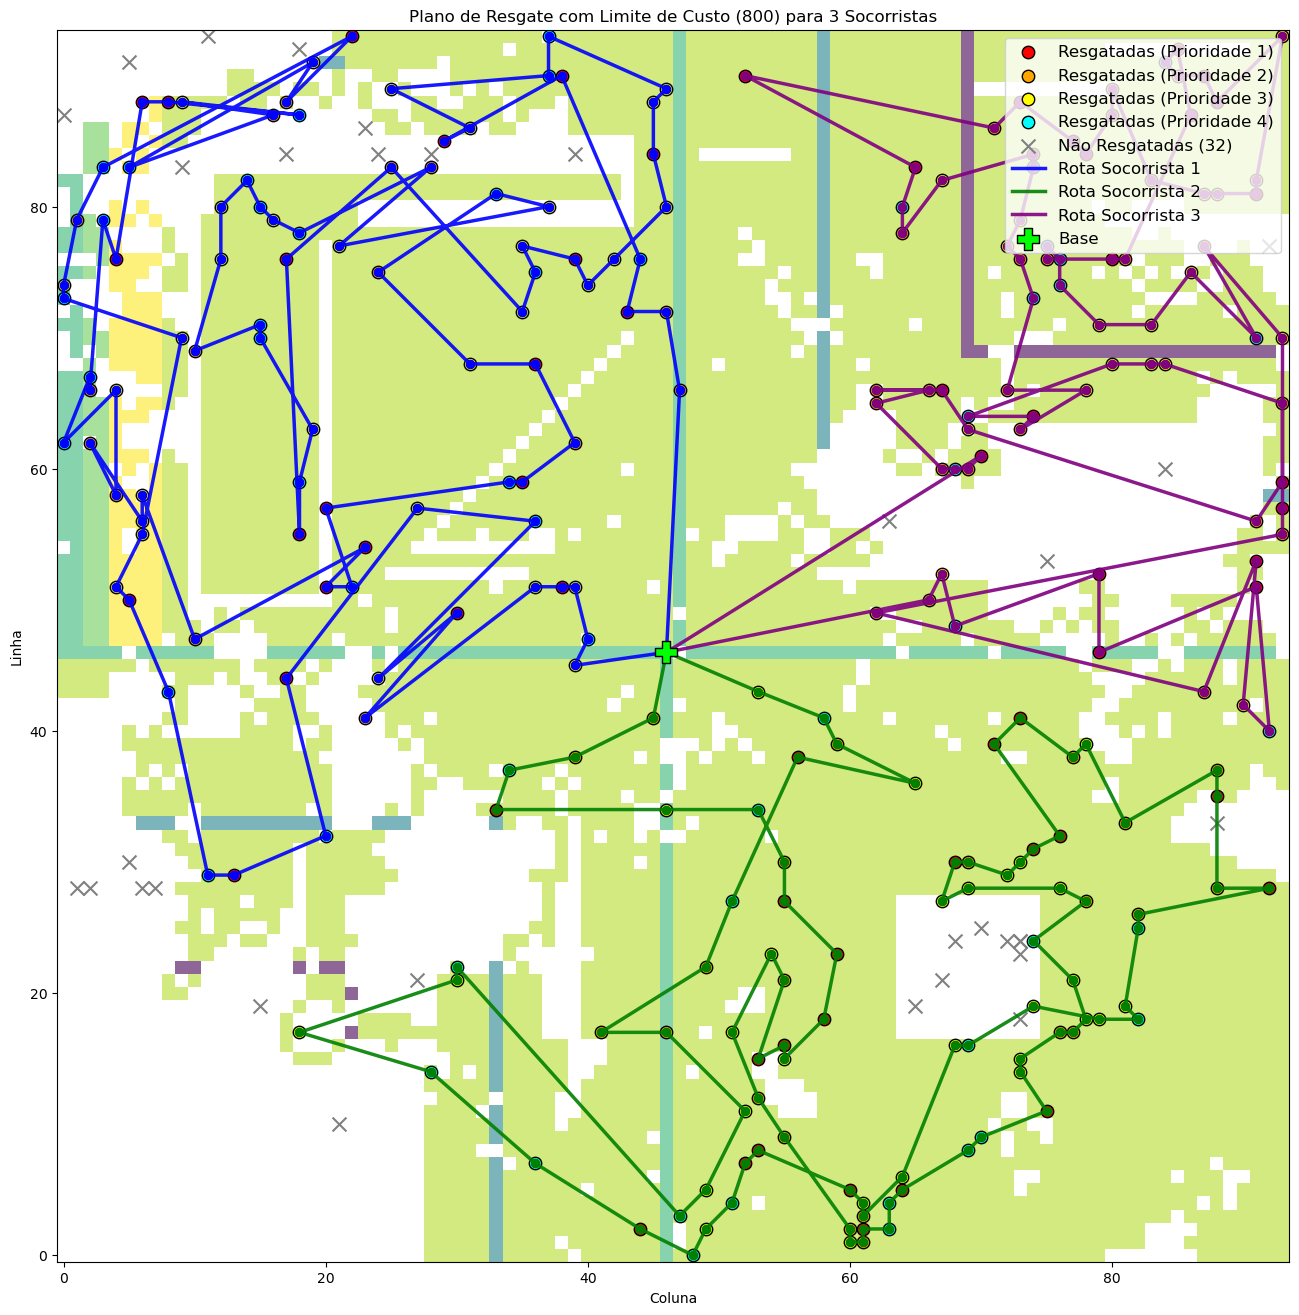

In [37]:
# --- Visualização dos Resultados com Limite de Custo ---
if any(agent_routes_limited):
    plt.figure(figsize=(16, 16))
    
    # Plotar o mapa de fundo (células conhecidas com seu custo)
    # Criar uma cópia do known_grid para não alterar o original
    display_grid = known_grid.copy()
    # Marcar células intransponíveis (inf) com um valor alto, mas plotável
    display_grid[display_grid == np.inf] = np.nan # Usar NaN para que o matplotlib os ignore
    plt.imshow(display_grid, cmap='viridis_r', origin='upper', alpha=0.6, 
               interpolation='nearest', label='Custo do Terreno (Conhecido)')

    # Plotar vítimas resgatadas
    if not rescued_victims_df.empty:
        colors_priority = ['red', 'orange', 'yellow', 'cyan']
        for priority in sorted(rescued_victims_df['priority'].unique()):
            priority_victims = rescued_victims_df[rescued_victims_df['priority'] == priority]
            plt.scatter(
                priority_victims['coluna'], 
                priority_victims['linha'], 
                c=colors_priority[priority-1], 
                s=80, 
                label=f'Resgatadas (Prioridade {priority})',
                edgecolors='black',
                linewidth=1.0
            )

    # Plotar vítimas não resgatadas (órfãs)
    if not unassigned_victims.empty:
        plt.scatter(
            unassigned_victims['coluna'],
            unassigned_victims['linha'],
            c='gray',
            s=100,
            marker='x',
            label=f'Não Resgatadas ({len(unassigned_victims)})',
            linewidth=1.5
        )

    # Plotar rotas dos agentes
    route_colors = ['blue', 'green', 'purple', 'brown']
    for i, agent_route in enumerate(agent_routes_limited):
        if not agent_route or len(agent_route) <= 2: continue
        
        route_x = [pos[1] for pos in agent_route]
        route_y = [pos[0] for pos in agent_route]
        
        plt.plot(route_x, route_y, '-', color=route_colors[i % len(route_colors)], 
                 label=f'Rota Socorrista {i+1}', alpha=0.9, linewidth=2.5)
        plt.plot(route_x, route_y, 'o', color=route_colors[i % len(route_colors)], markersize=6)

    # Plotar base
    plt.scatter(BASE[1], BASE[0], c='lime', s=250, marker='P', label='Base', zorder=10, edgecolors='black')

    plt.title(f'Plano de Resgate com Limite de Custo ({MAX_COST_PER_AGENT}) para {N_AGENTS} Socorristas')
    plt.xlabel('Coluna')
    plt.ylabel('Linha')
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(False)
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("\nNenhuma rota foi gerada com o limite de custo.")
    # Mesmo sem rotas, podemos querer ver as vítimas
    plt.figure(figsize=(12, 12))
    plt.imshow(known_grid, cmap='Greys', origin='upper', alpha=0.5)
    if not victims.empty:
        plt.scatter(victims['coluna'], victims['linha'], c='red', s=50, label='Vítimas')
    plt.title("Mapa de Vítimas (Nenhuma Rota Gerada)")
    plt.legend()
    plt.show()